In [0]:
!pip install torch_optimizer

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import cv2
import torch.optim as optim
import torch_optimizer as optim1
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensor #convert from numpy to tensor - augmentation also
%matplotlib inline
from sklearn.model_selection import train_test_split
from albumentations import (
    Compose, OneOf, Rotate, Flip, Blur, ToGray,GaussNoise, MedianBlur, 
   InvertImg, RandomBrightness, RandomContrast, Transpose, ChannelShuffle, HorizontalFlip, VerticalFlip,
    IAAAdditiveGaussianNoise,RandomRotate90, MotionBlur, ShiftScaleRotate, IAASharpen,
    RandomBrightnessContrast, CLAHE, HueSaturationValue ,OpticalDistortion,GridDistortion,IAAPiecewiseAffine, IAAEmboss
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [0]:
trainset = torchvision.datasets.MNIST(root = '', train = True, download=True);
num_classes = len(trainset.classes)
idx = np.random.randint(trainset.data.shape[0])

def load_data_and_plot(xtrain ,ytrain):
  lst_of_numbers = {}
  i = 0
  for label,img in zip(ytrain, xtrain):
    if label not in lst_of_numbers.keys():
      lst_of_numbers[label] = []
    lst_of_numbers[label] += [img]
  return lst_of_numbers

all_data = load_data_and_plot(trainset.data.numpy() ,trainset.targets.numpy())

def create_numbers_from_data(data):
  new_db = {}
  for number in range (0,101):
    new_db[number] = []
    for _ in range (0,1000):
      new_image = np.zeros((28,84), dtype= 'uint8') #size of new image
      unity = number % 10
      dozens = number // 10
      if number > 99:
        dozens = dozens % 10 
      hundreds = number // 100
      unity_img_lst = data[unity] #list of images of a number
      dozens_img_lst = data[dozens]
      hundreds_img_lst = data[hundreds] 
      which_unity_image = np.random.randint(0,len(unity_img_lst)) 
      which_dozens_image = np.random.randint(0,len(dozens_img_lst)) 
      which_hundreds_image = np.random.randint(0,len(hundreds_img_lst)) 
      unity_img = data[unity][which_unity_image] #unity of a number
      dozens_img = data[dozens][which_dozens_image] #dozen of a number
      hundreds_img = data[hundreds][which_hundreds_image] #hundreds of a number
      new_image[ :28, 56:84] = unity_img
      new_image[ :28, 28:56] = dozens_img
      new_image[ :28, :28] = hundreds_img
      new_db[number] += [new_image]
  return new_db

new_data = create_numbers_from_data(all_data)

def prepare_data(data):
    targets = [] 
    new_data = []
    for label,images in data.items():
        new_data += data[label]
        for img in images:
            targets += [label]
    return targets,new_data

targets, data = prepare_data(new_data)

In [0]:
class MNISTDataset(Dataset):
    def __init__(self, data, targets, transforms = None):
        super(MNISTDataset, self).__init__()
        self.x_train = data
        self.y_train = targets
        self.transform = transforms

    def __getitem__(self, idx):
        x = self.x_train[idx]
        y = self.y_train[idx]
        target = torch.zeros(101)
        target[y] = 1.0
        if self.transform:
            x = self.transform(image = x)
            x = x['image']
        return x, target
    
    def __len__(self):
        return len(self.x_train)

In [0]:
def make_augmantations(p = 0.5):
     return Compose([
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            IAASharpen(),
            IAAEmboss(),
        ], p=0.3),
    ], p=p)


In [0]:
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, random_state=42)
x_train1, x_val, y_train1, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
mnist_transforms = make_augmantations()

mnist_dataset = MNISTDataset(x_train,y_train, transforms=mnist_transforms)
mnist_val = MNISTDataset(x_val,y_val)
mnist_test = MNISTDataset(x_test,y_test)

BS = 250
mnist_dataloader_train= DataLoader(mnist_dataset, batch_size=BS , shuffle=True)
mnist_dataloader_val= DataLoader(mnist_val, batch_size=BS , shuffle=True)
mnist_dataloader_test = DataLoader(mnist_test, batch_size=BS , shuffle=True)

In [0]:
#image size : 28X84X1
    #dim_after_conv = input_size -(filter_zise - 1)
    #dim_after_max_pool = input_size /2 

    # size of input image :  28x84x1
    # after first conv2d : 28 - (5 -1) = 24, #84 - (5-1) = 80  
    # img size : 24x80x6

    # after max_pool :24/2 = 12 , #80/2 =40
    # img size = 12x40x6

    #after 2nd conv2d : 12 - (5-1) = 8 , #40 - (5-1) = 36
    #img size : 8x36x16

    # after max_pool :8/2= 4, #36/2 = 18
    # img size = 4x18x16
class LeNet(nn.Module): 
    def __init__(self):
        super(LeNet ,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16*18*4 ,out_features = 120)
        self.fc2 = nn.Linear(in_features=120 ,out_features = 84)                              
        self.fc3 = nn.Linear(in_features=84 ,out_features = 101)

    def forward(self, x):
        x = self.conv1(x.float())
    
        x = F.relu(x)
        x = F.max_pool2d(x ,2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)
        x = F.softmax(x,dim = 1).double()
        return x

In [0]:
def optimizers(params,option): 
    if option == 'sgd':
        optimizer = optim.SGD(params,lr=0.01)
    if option == 'adam':
        optimizer = optim.Adam(params,lr=0.001,betas=(0.9,0.999),eps=1e-8)
    if option == 'radam':
        optimizer = optim1.RAdam(params,lr=1e-3,betas=(0.9,0.999),eps=1e-8)
    return optimizer


In [0]:
lene = LeNet()

In [0]:
lene.to(device)

In [0]:
adam_optim = optimizers(lene.parameters(),'adam')

In [0]:
def focal_loss1(input1, target,alpha, gamma):
    BCE_loss = F.binary_cross_entropy(input1, target)
    pt = torch.exp(-BCE_loss)
    return (alpha)* ((1-pt)**gamma)* BCE_loss

In [0]:
def evaluation(actual, pred, one_hot = True):
    acuuracy = 0.0
    total_hits = 0.0 
    lst_actual = list()
    lst_pred = list()
    if one_hot:
        for a in actual :
            lst_actual.append(torch.argmax(a))
        for p in pred : 
            lst_pred.append(torch.argmax(p))

    for a,p in zip(lst_actual , lst_pred):
        if a == p:
            total_hits += 1.0
    acuuracy = total_hits / len(actual)
    return acuuracy

In [14]:
def training_loop(data_loader):
    conv_list = list()
    accur_lst = list()
    for _ in range(3):
        acc_loss = 0.0
        for i, sample in enumerate(data_loader, 0):
            x_train, y_train = sample[0].to(device), sample[1].to(device)
            adam_optim.zero_grad()
            output = lene(x_train[:, np.newaxis, :])
            acc = evaluation(y_train, output, one_hot = True)
            accur_lst.append(acc)
            loss = focal_loss1(output, y_train.double(), alpha=1, gamma=2) 
            conv_list.append(loss.item())
            loss.backward()
            adam_optim.step()
            acc_loss += loss.item()
            if i %20==19:
                print('[%d, %5d] loss: %.15f, accuracy: %f' %(_ + 1, i + 1, acc_loss/20, acc))
                acc_loss = 0.0
    return conv_list, accur_lst

conv_list1, accur_lst1 = training_loop(mnist_dataloader_train)

[1,    20] loss: 0.000185369714621, accuracy: 0.016000
[1,    40] loss: 0.000151702399320, accuracy: 0.080000
[1,    60] loss: 0.000119104246078, accuracy: 0.156000
[1,    80] loss: 0.000079512001310, accuracy: 0.308000
[1,   100] loss: 0.000054722699990, accuracy: 0.416000
[1,   120] loss: 0.000040552602753, accuracy: 0.408000
[1,   140] loss: 0.000030757620559, accuracy: 0.520000
[1,   160] loss: 0.000023942221822, accuracy: 0.504000
[1,   180] loss: 0.000020345007982, accuracy: 0.560000
[1,   200] loss: 0.000016838375989, accuracy: 0.584000
[1,   220] loss: 0.000014627434939, accuracy: 0.644000
[1,   240] loss: 0.000014137848189, accuracy: 0.656000
[1,   260] loss: 0.000011939901435, accuracy: 0.580000
[1,   280] loss: 0.000012592452184, accuracy: 0.660000
[1,   300] loss: 0.000010702497043, accuracy: 0.668000
[1,   320] loss: 0.000010116058823, accuracy: 0.620000
[2,    20] loss: 0.000009971912937, accuracy: 0.676000
[2,    40] loss: 0.000009418253653, accuracy: 0.604000
[2,    60]

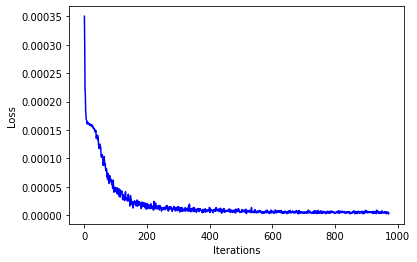

In [15]:
plt.plot(conv_list1,'b')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

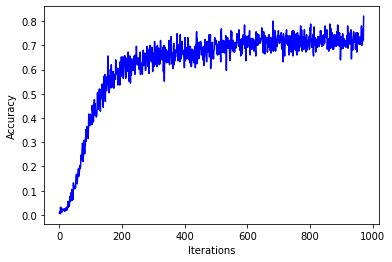

In [17]:
plt.plot(accur_lst1,'b')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

In [18]:
conv_list1, accur_lst1 = training_loop(mnist_dataloader_val)

[1,    20] loss: 0.000003672900913, accuracy: 0.748000
[2,    20] loss: 0.000003092036444, accuracy: 0.744000
[3,    20] loss: 0.000002905795343, accuracy: 0.748000


In [19]:
conv_list1, accur_lst1 = training_loop(mnist_dataloader_test)

[1,    20] loss: 0.000003923637644, accuracy: 0.748000
[1,    40] loss: 0.000003476209337, accuracy: 0.764000
[1,    60] loss: 0.000003842772959, accuracy: 0.652000
[1,    80] loss: 0.000003989584892, accuracy: 0.728000
[2,    20] loss: 0.000003293613702, accuracy: 0.784000
[2,    40] loss: 0.000003248590203, accuracy: 0.728000
[2,    60] loss: 0.000003002582062, accuracy: 0.740000
[2,    80] loss: 0.000003321964206, accuracy: 0.748000
[3,    20] loss: 0.000003013947610, accuracy: 0.744000
[3,    40] loss: 0.000003148692920, accuracy: 0.708000
[3,    60] loss: 0.000002712491284, accuracy: 0.764000
[3,    80] loss: 0.000003039234986, accuracy: 0.732000


In [0]:
x_test = torch.from_numpy(np.array(x_test))
y_test = torch.from_numpy(np.array(y_test))
pred = lene(x_test[:, np.newaxis, :].to(device))
pred = [torch.argmax(x.detach().cpu()) for x in pred]
pred = torch.stack(pred)

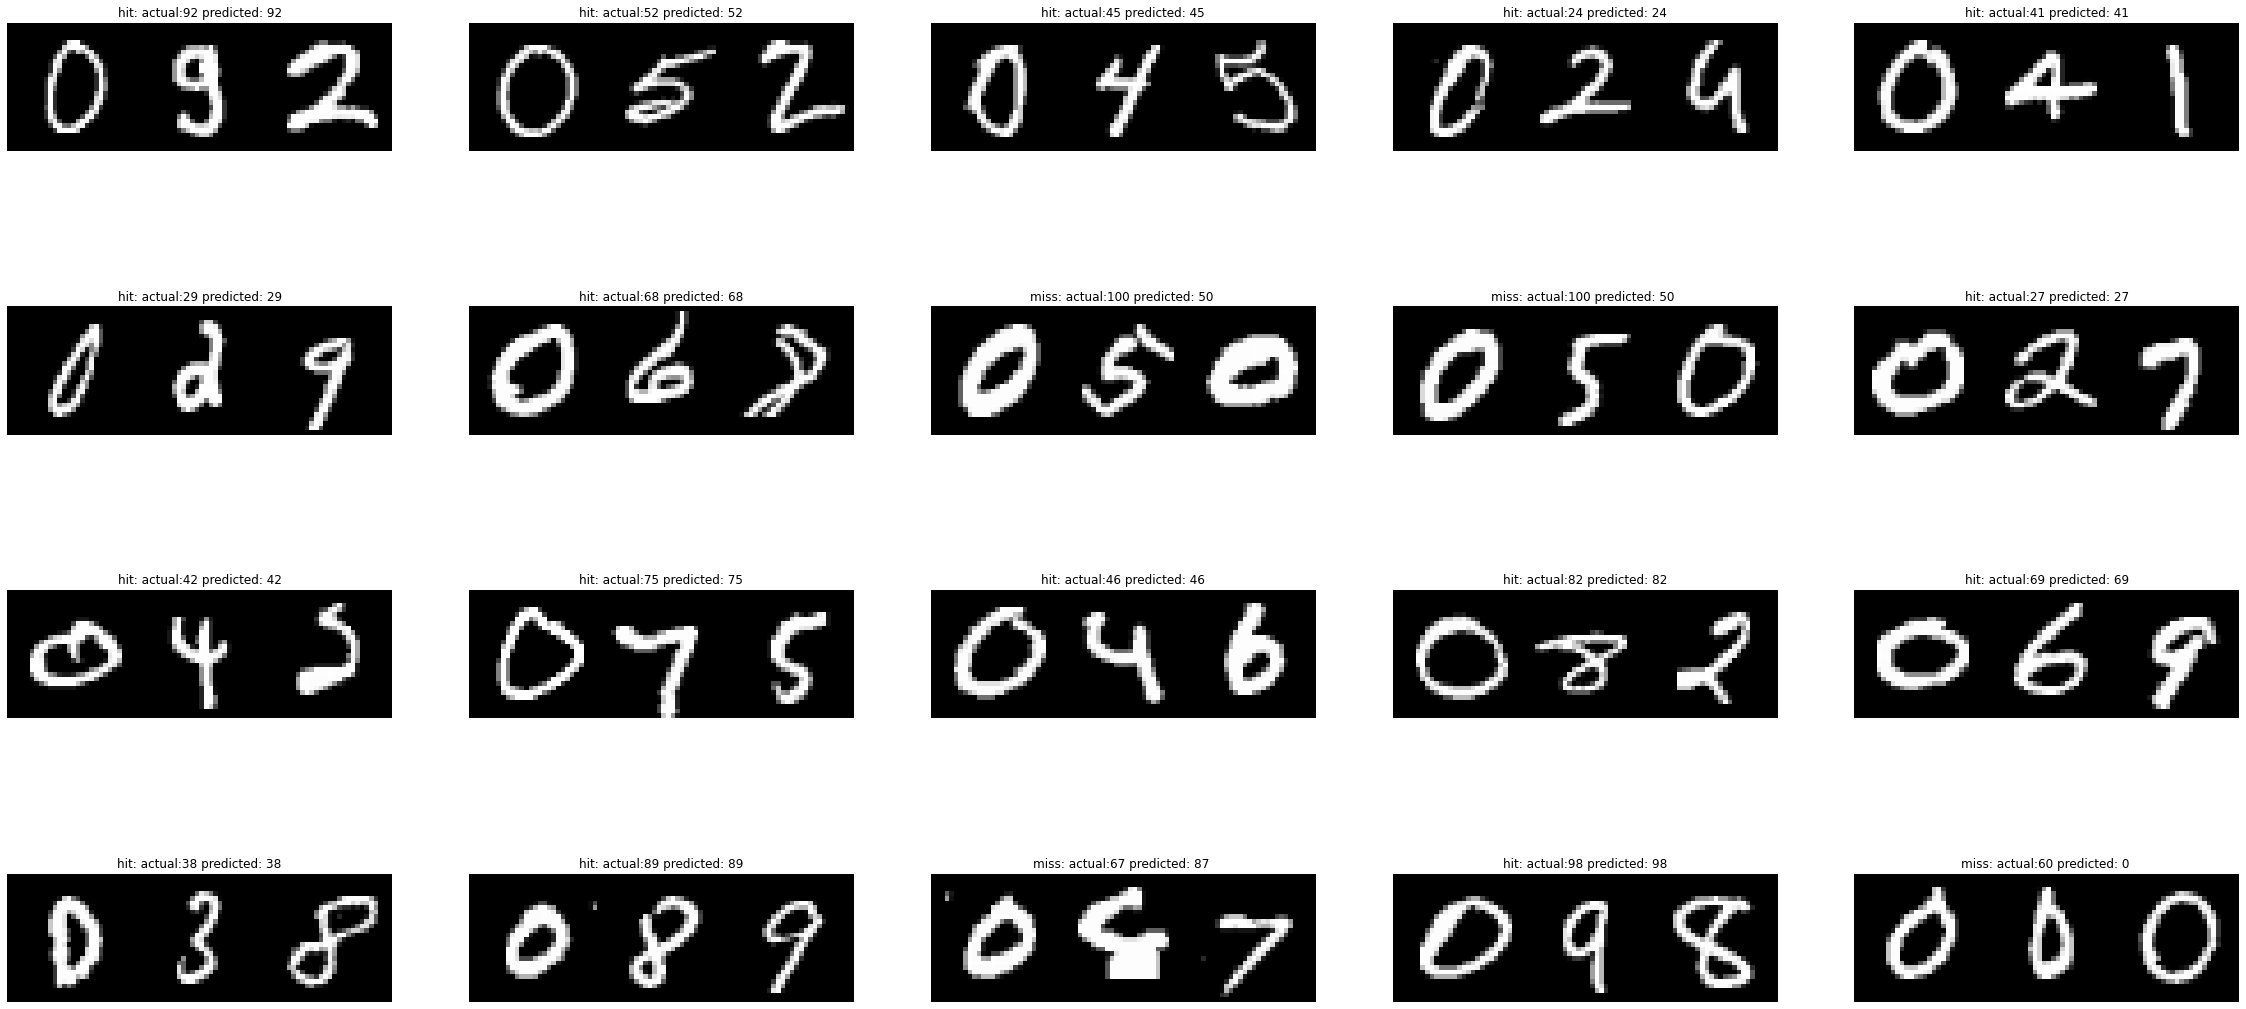

In [25]:
hit_counter = 0
miss_counter = 0

plt.figure(figsize = [40, 20])
for i,(actual,pred1) in enumerate(zip(pred.numpy(),y_test.numpy())):
    if actual == pred1:
        hit_counter += 1
        plt.subplot(4,5, i + 1)
        plt.imshow(x_test[i],cmap = 'gray')
        plt.title(f"hit: actual:{actual} predicted: {pred1}")
        plt.axis('off')
    else:
        miss_counter += 1
        plt.subplot(4, 5, i + 1)
        plt.imshow(x_test[i],cmap = 'gray')
        plt.title(f"miss: actual:{actual} predicted: {pred1} ")
        plt.axis('off')

    if hit_counter > 3 and miss_counter > 3 :
        break 
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


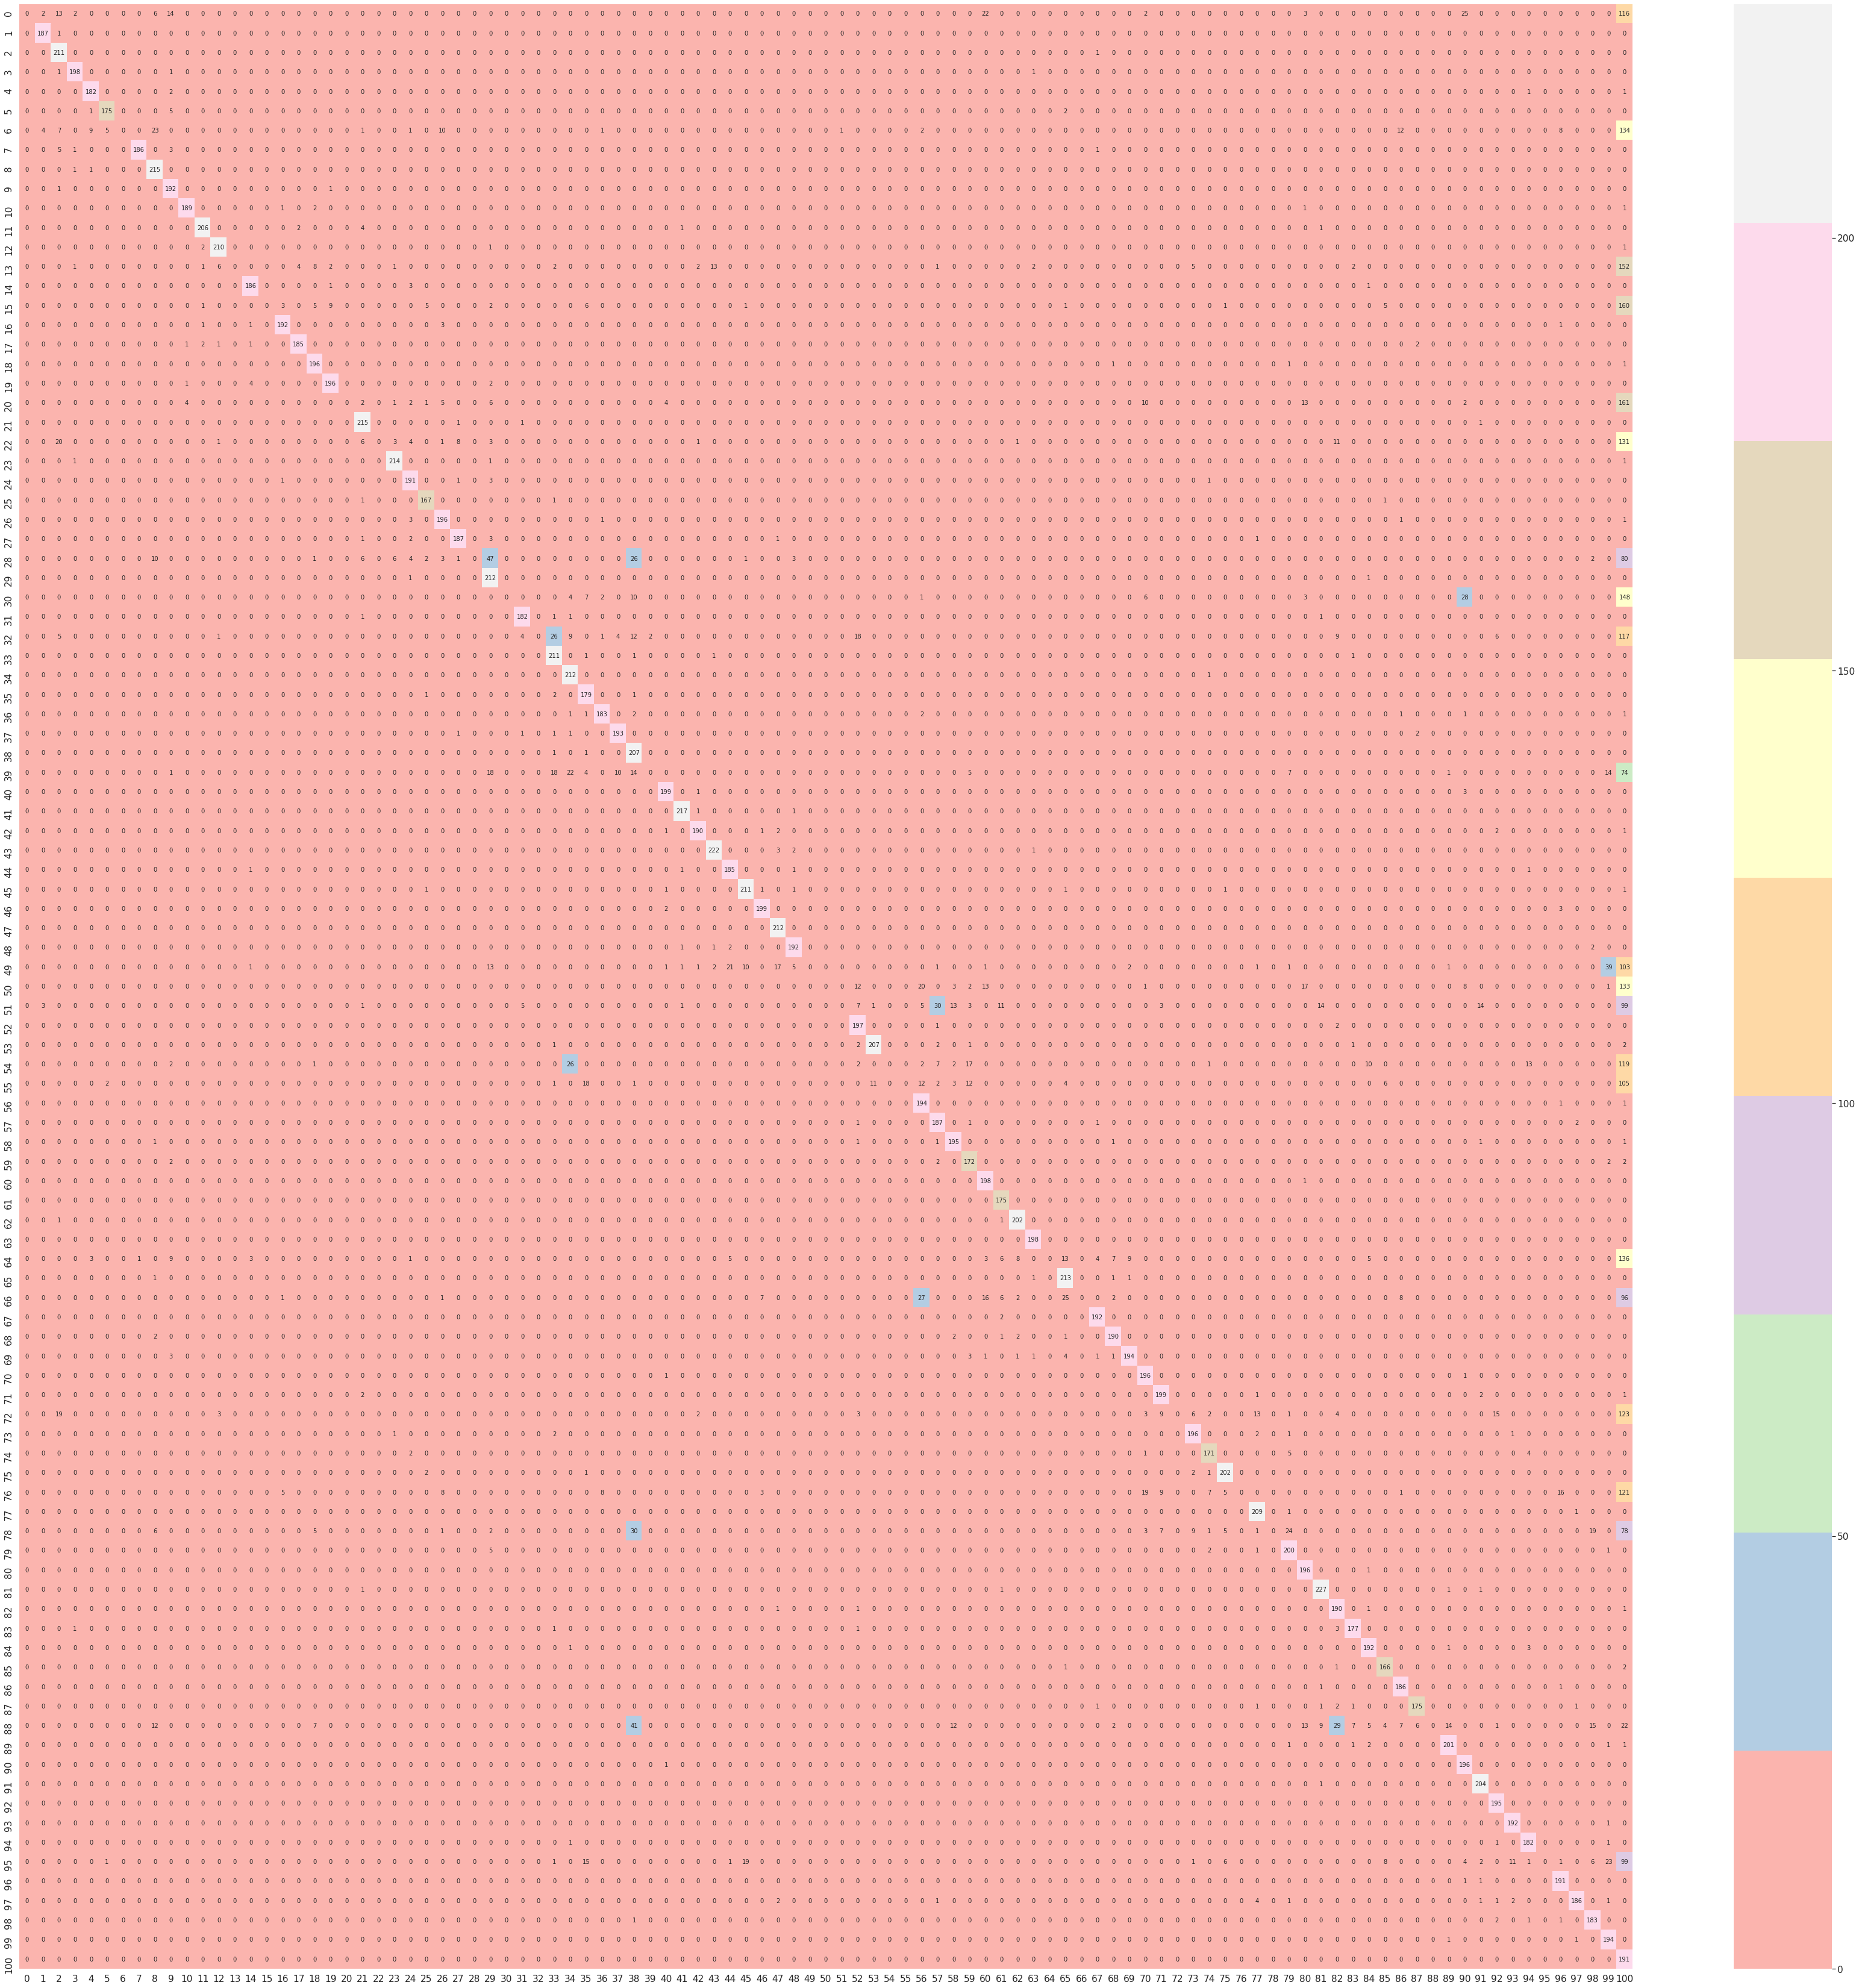

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index = [i for i in range(101)],
                  columns = [i for i in range(101)])
plt.figure(figsize = (60,60))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10},cmap='Pastel1',fmt='g'); # font size
